# unsafe_mfdataset demo

`unsafe_mfdataset()` constructs a virtual file for a large collection, without having to open all of the individual files. It makes some assumptions that could be invalid in some situations

In [2]:
%matplotlib inline
from coecms.bigdata import unsafe_mfdataset
import pandas
import xarray
from pandas.tseries.offsets import *

/short/w35/saw562/conda/envs/coecms/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## ERA-Interim

Era-Interim has one file per month, with names like

    /g/data1/ub4/erai/netcdf/3hr/atmos/oper_fc_sfc/v01/tas/tas_3hrs_ERAI_historical_fc-sfc_20040101_20040131.nc
    
Each file contains 3 hourly data, from 0300 on the first of the month, to 0000 on the first of the following month

In [81]:
def erai_path(date):
    date = date - 3*Hour()
    mstart = (date - MonthEnd() + Day()).strftime('%Y%m%d')
    mend = (date + MonthBegin() - Day()).strftime('%Y%m%d')
    return f'/g/data1/ub4/erai/netcdf/3hr/atmos/oper_fc_sfc/v01/tas/tas_3hrs_ERAI_historical_fc-sfc_{mstart}_{mend}.nc'

In [82]:
# Check the paths are printed correctly
sample = '/g/data1/ub4/erai/netcdf/3hr/atmos/oper_fc_sfc/v01/tas/tas_3hrs_ERAI_historical_fc-sfc_20040101_20040131.nc'

assert erai_path(pandas.to_datetime('20040101T0300')) == sample
assert erai_path(pandas.to_datetime('20040103T1800')) == sample
assert erai_path(pandas.to_datetime('20040201T0000')) == sample

In [4]:
dates = pandas.date_range('19810101', '20171231', freq='MS')
paths = [erai_path(d) for d in dates]

In [5]:
ds = unsafe_mfdataset(paths)
ds

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480, time: 108112)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 87.0 86.25 85.5 84.75 84.0 ...
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 -177.0 -176.2 -175.5 ...
  * time     (time) datetime64[ns] 1981-01-01T03:00:00 1981-01-01T06:00:00 ...
Data variables:
    tas      (time, lat, lon) float32 dask.array<shape=(108112, 241, 480), chunksize=(248, 241, 480)>
Attributes:
    CDI:          Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Thu Sep  3 10:14:33 2015: ncks -O --md5_wrt_att -v tas 2T_1...
    CDO:          Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/...
    title:        ERA-Interim 2 metre temperature [K] forecast on surface (gl...
    institution:  ARCCSS ARC Centre of Excellence for Climate System Science ...
    source:       Original grib files obtained from http://apps.ecmwf.int/dat...
    references:   Please acknowledge both 

[########################################] | 100% Completed | 22.9s


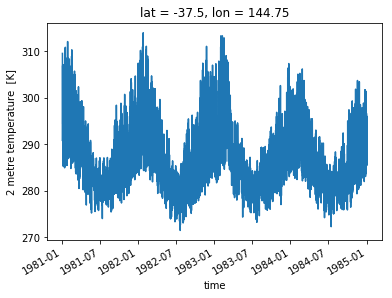

In [84]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    da = ds.tas.sel(lat=-37.8136, lon=144.9631, method='nearest').sel(time=slice(None, '19850101'))
    da.plot()

## MUR

MUR data has one file per day, with OpenDAP urls like

    https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2002/152/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc

In [3]:
def mur_path(date):
    yyyy = date.year
    doy = date.dayofyear
    yyyymmdd = date.strftime('%Y%m%d')
    return f'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/{yyyy}/{doy}/{yyyymmdd}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [4]:
mur_path(pandas.to_datetime('20020601'))

'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2002/152/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [ ]:
paths = [mur_path(d) for d in pandas.date_range('20020301','20020305')]
ds = unsafe_mfdataset(paths, chunks={'lat':1000, 'lon': 1000})
ds